# Finding Eigenvalues of Real, Symetric Matrices with Neural Networks

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

sys.path.insert(0, "../src")
from utils import minibatch, heat_eq_analytic

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
})

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

Following the method proposed by Yi et al, we may find the eigenvalues of a real, symmetric matrix A by solving the differential equation

$$
    \frac{d \pmb x(t)}{d t} = - \pmb x(t) + f(\pmb x(t))
$$

where 

$$
    f(\pmb  x) = [\pmb x^T \pmb x A + (1 - \pmb x^T A \pmb x)I] \pmb x
$$

In [2]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        N_curr = N[i].reshape(-1,1)
        v = trial_func(t[i], N_curr)
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N_curr), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
            
        # Increment the loss function
        loss = loss + (dfdt[:, 0] - RHS).pow(2).mean()
    
    return loss / t.size(0)

In [3]:
# Set a seed for reproducability. 
torch.manual_seed(2020)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q

In [31]:
for i in range(6):
    for j in range(6):
        if j < 5:
            print(" %.1f" % A.detach().numpy()[i,j], end=" &")
        else: 
            print(" %.f" % A.detach().numpy()[i,j], end=" ")
    print("\\\\")

 -0.0 & 0.7 & -2.4 & 0.6 & 0.3 & -3 \\
 0.7 & -3.4 & 1.2 & -0.2 & -1.4 & -1 \\
 -2.4 & 1.2 & -1.7 & -0.4 & -1.1 & -0 \\
 0.6 & -0.2 & -0.4 & 1.7 & 2.1 & -1 \\
 0.3 & -1.4 & -1.1 & 2.1 & -3.5 & 1 \\
 -2.8 & -1.0 & -0.4 & -0.7 & 0.5 & -2 \\


In [5]:
eigval, eigvec = np.linalg.eigh(A.detach().numpy())

with np.printoptions(precision=2):
    print("",eigval)
    print()
    print(eigvec)

 [-5.42 -4.78 -3.9  -0.12  1.77  3.72]

[[-0.38  0.45 -0.1   0.12 -0.54  0.58]
 [ 0.56  0.18 -0.64 -0.42 -0.24 -0.02]
 [-0.31  0.51  0.28 -0.66  0.09 -0.34]
 [-0.17 -0.14 -0.21 -0.35  0.63  0.63]
 [ 0.58  0.56  0.38  0.25  0.3   0.24]
 [-0.29  0.41 -0.55  0.43  0.39 -0.32]]


In [6]:
# Number of points to train on
num_points = 40

# normalized time domain for ODE
t = torch.linspace(0, 2, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
v0 = v0 / torch.norm(v0)

# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

In [7]:
# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

learning_rate = 2e-2
N_minibatches = 1#int(num_points / 12)
print(N_minibatches)

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


TOT_EPOCHS_10 = 0

loss_arr_tot_10 = np.empty(0, dtype=np.float)
epoch_arr_tot_10 = np.empty(0, dtype=np.float)

1


1000: loss =  tensor(2.5248e-05, grad_fn=<DivBackward0>)
1010: loss =  tensor(3.7295e-06, grad_fn=<DivBackward0>)
1020: loss =  tensor(2.5449e-05, grad_fn=<DivBackward0>)
1030: loss =  tensor(3.2958e-05, grad_fn=<DivBackward0>)
1040: loss =  tensor(4.0866e-06, grad_fn=<DivBackward0>)
1050: loss =  tensor(2.2009e-05, grad_fn=<DivBackward0>)
1060: loss =  tensor(6.0606e-05, grad_fn=<DivBackward0>)
1070: loss =  tensor(9.0432e-06, grad_fn=<DivBackward0>)
1080: loss =  tensor(2.9195e-06, grad_fn=<DivBackward0>)
1090: loss =  tensor(4.4272e-05, grad_fn=<DivBackward0>)
1100: loss =  tensor(2.8475e-05, grad_fn=<DivBackward0>)
1110: loss =  tensor(0.0003, grad_fn=<DivBackward0>)
1120: loss =  tensor(2.7592e-05, grad_fn=<DivBackward0>)
1130: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
1140: loss =  tensor(4.1675e-05, grad_fn=<DivBackward0>)
1150: loss =  tensor(1.8124e-05, grad_fn=<DivBackward0>)
1160: loss =  tensor(8.7715e-06, grad_fn=<DivBackward0>)
1170: loss =  tensor(6.7646e-06, grad_f

2450: loss =  tensor(4.0815e-05, grad_fn=<DivBackward0>)
2460: loss =  tensor(3.6446e-05, grad_fn=<DivBackward0>)
2470: loss =  tensor(1.6764e-05, grad_fn=<DivBackward0>)
2480: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
2490: loss =  tensor(2.1688e-05, grad_fn=<DivBackward0>)
2500: loss =  tensor(5.5098e-05, grad_fn=<DivBackward0>)
2510: loss =  tensor(1.6502e-05, grad_fn=<DivBackward0>)
2520: loss =  tensor(9.6388e-05, grad_fn=<DivBackward0>)
2530: loss =  tensor(9.5167e-06, grad_fn=<DivBackward0>)
2540: loss =  tensor(8.4946e-05, grad_fn=<DivBackward0>)
2550: loss =  tensor(5.8868e-06, grad_fn=<DivBackward0>)
2560: loss =  tensor(9.5979e-05, grad_fn=<DivBackward0>)
2570: loss =  tensor(3.9964e-06, grad_fn=<DivBackward0>)
2580: loss =  tensor(7.8224e-05, grad_fn=<DivBackward0>)
2590: loss =  tensor(3.4381e-06, grad_fn=<DivBackward0>)
2600: loss =  tensor(7.9912e-05, grad_fn=<DivBackward0>)
2610: loss =  tensor(1.3325e-06, grad_fn=<DivBackward0>)
2620: loss =  tensor(6.3146e-05, gr

Text(0.5, 0, 'Epoch')

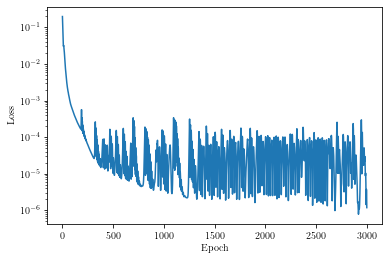

In [34]:
EPOCHS = 2000

loss_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model(t[mb[i]])
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A, f_trial)
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    N_output = model(t) 
    loss = costfunction(t, N_output, A, f_trial)
    # Compute loss of entire sample
    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_10 + epoch}: loss = ",loss) 
    loss_arr_curr_10[epoch] = loss
    epoch_arr_curr_10[epoch] = TOT_EPOCHS_10 + epoch  
        
        
TOT_EPOCHS_10 += EPOCHS    
loss_arr_tot_10 = np.append(loss_arr_tot_10, loss_arr_curr_10)
epoch_arr_tot_10 = np.append(epoch_arr_tot_10, epoch_arr_curr_10)

plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")

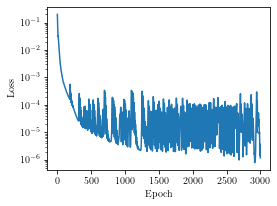

In [35]:
plt.figure(figsize=(4,3))
plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("../figs/eigenval_loss.pdf")

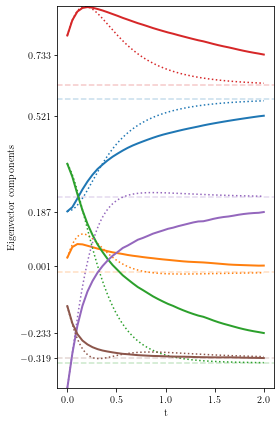

In [36]:
N_output = model(t) 
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(4, 6))
#plt.subplot(121)

y_min = min([np.amin(x_euler), np.amin(v_pred_np)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np)])

for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], ls = "solid", color=colors[d], linewidth=2)
    plt.plot(time, x_euler[:, d], ls=":" , color=colors[d], linewidth=1.5)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
#plt.yticks(x_euler[-1, :])
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min,y_max)
plt.xlabel("t")

#plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#plt.gca().yaxis.set_label_position("right")
plt.ylabel("Eigenvector components")

"""
plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], "o", color=colors[d], linewidth=3)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min, y_max)
plt.xlabel("t")
"""

plt.tight_layout()
plt.savefig("../figs/eigenvec_dynamics.pdf")
plt.show()

In [37]:
# Compute eigenvalue
eigval_nn = (v_pred_np[-1, :].T @ A_t @ v_pred_np[-1, :] / (v_pred_np[-1, :].T @ v_pred_np[-1, :]))
print("NN Eigenvalue: %10.3f" 
      % eigval_nn)
print("Numpy Eigenvalue: %7.3f" % eigval[-1])

with np.printoptions(precision=3):
    print("\nEigenvectors:")
    print(v_pred_np[-1, :], "NN")
    print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: %.3f" % np.dot(eigvec[:, -1], v_pred_np[-1, :]))

NN Eigenvalue:      3.614
Numpy Eigenvalue:   3.722

Eigenvectors:
[ 0.521  0.001 -0.233  0.733  0.187 -0.319] NN
[ 0.578 -0.021 -0.337  0.627  0.239 -0.318] Numpy

dot product: 0.986


## Compute the smalles eigenvalue & Eigenvector

In [38]:
A_neg = - torch.clone(A)
A_neg

tensor([[ 0.0173, -0.7011,  2.4403, -0.6338, -0.3444,  2.7550],
        [-0.7011,  3.4166, -1.1724,  0.2233,  1.4215,  0.9924],
        [ 2.4403, -1.1724,  1.7178,  0.4207,  1.0524,  0.3791],
        [-0.6338,  0.2233,  0.4207, -1.7434, -2.0975,  0.7133],
        [-0.3444,  1.4215,  1.0524, -2.0975,  3.5050, -0.5459],
        [ 2.7550,  0.9924,  0.3791,  0.7133, -0.5459,  1.8151]])

In [13]:
# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

learning_rate = 2e-2
N_minibatches = 1#int(num_points / 12)
print(N_minibatches)

model_small = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=learning_rate)


TOT_EPOCHS_small = 0

loss_arr_tot_small = np.empty(0, dtype=np.float)
epoch_arr_tot_small = np.empty(0, dtype=np.float)

1


1000: loss =  tensor(1.6278e-05, grad_fn=<DivBackward0>)
1010: loss =  tensor(1.7906e-05, grad_fn=<DivBackward0>)
1020: loss =  tensor(7.9514e-06, grad_fn=<DivBackward0>)
1030: loss =  tensor(2.9511e-05, grad_fn=<DivBackward0>)
1040: loss =  tensor(2.9683e-05, grad_fn=<DivBackward0>)
1050: loss =  tensor(3.2959e-05, grad_fn=<DivBackward0>)
1060: loss =  tensor(1.9512e-05, grad_fn=<DivBackward0>)
1070: loss =  tensor(1.7016e-05, grad_fn=<DivBackward0>)
1080: loss =  tensor(8.1654e-05, grad_fn=<DivBackward0>)
1090: loss =  tensor(3.9579e-05, grad_fn=<DivBackward0>)
1100: loss =  tensor(6.2417e-06, grad_fn=<DivBackward0>)
1110: loss =  tensor(5.8230e-05, grad_fn=<DivBackward0>)
1120: loss =  tensor(9.3589e-06, grad_fn=<DivBackward0>)
1130: loss =  tensor(1.5882e-05, grad_fn=<DivBackward0>)
1140: loss =  tensor(1.5028e-05, grad_fn=<DivBackward0>)
1150: loss =  tensor(7.5990e-05, grad_fn=<DivBackward0>)
1160: loss =  tensor(3.7442e-05, grad_fn=<DivBackward0>)
1170: loss =  tensor(5.7622e-06

2450: loss =  tensor(3.1760e-05, grad_fn=<DivBackward0>)
2460: loss =  tensor(3.1534e-05, grad_fn=<DivBackward0>)
2470: loss =  tensor(6.0666e-06, grad_fn=<DivBackward0>)
2480: loss =  tensor(2.0038e-05, grad_fn=<DivBackward0>)
2490: loss =  tensor(2.7958e-05, grad_fn=<DivBackward0>)
2500: loss =  tensor(2.7898e-06, grad_fn=<DivBackward0>)
2510: loss =  tensor(3.7835e-05, grad_fn=<DivBackward0>)
2520: loss =  tensor(2.9695e-05, grad_fn=<DivBackward0>)
2530: loss =  tensor(5.7183e-05, grad_fn=<DivBackward0>)
2540: loss =  tensor(4.9507e-06, grad_fn=<DivBackward0>)
2550: loss =  tensor(3.8750e-05, grad_fn=<DivBackward0>)
2560: loss =  tensor(2.9828e-05, grad_fn=<DivBackward0>)
2570: loss =  tensor(2.8264e-06, grad_fn=<DivBackward0>)
2580: loss =  tensor(1.6647e-05, grad_fn=<DivBackward0>)
2590: loss =  tensor(3.1624e-05, grad_fn=<DivBackward0>)
2600: loss =  tensor(5.5118e-06, grad_fn=<DivBackward0>)
2610: loss =  tensor(4.5745e-06, grad_fn=<DivBackward0>)
2620: loss =  tensor(7.6162e-05

Text(0.5, 0, 'Epoch')

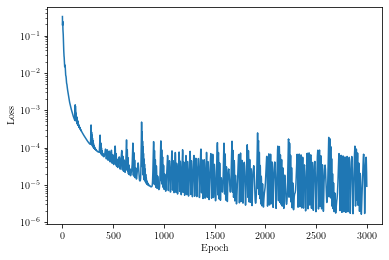

In [33]:
EPOCHS = 2000

loss_arr_curr_small = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_small = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_small(t[mb[i]])
        
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A_neg, f_trial)
        # Use autograd to compute the backward pass.
        optimizer_small.zero_grad()
        loss.backward()
        optimizer_small.step()
        
    N_output = model_small(t) 
    loss = costfunction(t, N_output, A_neg, f_trial)
    # Compute loss of entire sample
    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_small + epoch}: loss = ",loss) 
    loss_arr_curr_small[epoch] = loss
    epoch_arr_curr_small[epoch] = TOT_EPOCHS_small + epoch  
        
        
TOT_EPOCHS_small += EPOCHS    
loss_arr_tot_small = np.append(loss_arr_tot_small, loss_arr_curr_small)
epoch_arr_tot_small = np.append(epoch_arr_tot_small, epoch_arr_curr_small)

plt.semilogy(epoch_arr_tot_small, loss_arr_tot_small)
plt.ylabel("Loss")
plt.xlabel("Epoch")

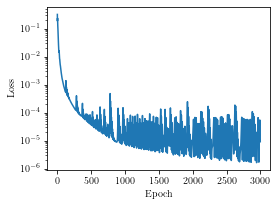

In [39]:
plt.figure(figsize=(4,3))
plt.semilogy(epoch_arr_tot_small, loss_arr_tot_small)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("../figs/eigenval_small_loss.pdf")

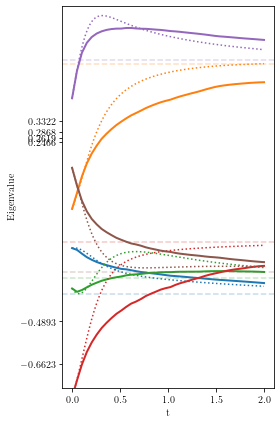

In [40]:
N_output = model_small(t) 
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A_neg.detach().numpy()
dt = 0.01
N = 200
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(4, 6))
#plt.subplot(121)

y_min = min([np.amin(x_euler), np.amin(v_pred_np)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np)])

for d in range(6):
    plt.plot(t.detach().numpy(), -v_pred_np[:, d], ls = "solid", color=colors[d], linewidth=2)
    plt.plot(time, -x_euler[:, d], ls=":" , color=colors[d], linewidth=1.5)
    plt.axhline(eigvec[d, 0], alpha=0.25, color=colors[d], ls="--")

plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min,y_max)
plt.xlabel("t")

#plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#plt.gca().yaxis.set_label_position("right")
plt.ylabel("Eigenvalue")

"""
plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], "o", color=colors[d], linewidth=3)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min, y_max)
plt.xlabel("t")
"""

plt.tight_layout()
#plt.savefig("test.png")
plt.show()

In [42]:
# Compute eigenvalue
eigval_nn = ((-v_pred_np[-1, :]).T @ A_t @ (-v_pred_np[-1, :]) / ((-v_pred_np[-1, :]).T @ (-v_pred_np[-1, :])))
print("NN Eigenvalue: %10.3f" 
      % eigval_nn)
print("Numpy Eigenvalue: %7.3f" % eigval[0])

with np.printoptions(precision=3):
    print("\nEigenvectors:")
    print(v_pred_np[-1, :], "NN")
    print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: %.3f" % np.dot(eigvec[:, 0], -v_pred_np[-1, :]))

NN Eigenvalue:      5.343
Numpy Eigenvalue:  -5.419

Eigenvectors:
[ 0.332 -0.489  0.287  0.262 -0.662  0.247] NN
[ 0.578 -0.021 -0.337  0.627  0.239 -0.318] Numpy

dot product: 0.987
